# Imports

In [47]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from pylab import rcParams
from tqdm.autonotebook import tqdm

import core.signal_processing as sp
import vendors.kibot.utils as kut
import vendors.particle_one.price_movement_analysis as pma

# import vendors.particle_one.PartTask269_liquidity_analysis_utils as lau

sns.set()

rcParams["figure.figsize"] = (20, 5)

In [49]:
TAU = 2

# Load CME metadata

In [50]:
# Change this to library code from #269 once it is merged into master

In [51]:
_PRODUCT_SPECS_PATH = (
    #"/data/prices/product_slate_export_with_contract_specs_20190905.csv"
    "s3://default00-bucket/cme/product_slate_export_with_contract_specs_20190905.csv"
)
product_list = pd.read_csv(_PRODUCT_SPECS_PATH)

In [52]:
product_list.head()

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,...,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
0,ED,GE,NaN,ED,Eurodollar Futures,Interest Rate,Stirs,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,ZF,NaN,25,5-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ZN,NaN,21,10-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26,ZT,NaN,26,2-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ES,ES,NaN,ES,E-mini S&P 500 Futures,Equities,US Index,NaN,NaN,Futures,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
product_list["Product Group"].value_counts()

Energy           892
Equities         100
Agriculture       57
FX                55
Metals            44
Interest Rate     30
Name: Product Group, dtype: int64

In [54]:
product_list.set_index("Product Group", inplace=True)

In [55]:
commodity_groups = ["Energy", "Agriculture", "Metals"]

In [56]:
commodity_symbols = {
    group: product_list.loc[group]["Globex"].values for group in commodity_groups
}

In [57]:
commodity_symbols

{'Energy': array(['CL', 'NG', 'NN', 'N9L', 'D2L', 'HO', 'RB', 'H2L', 'HH', 'BZ',
        'V3L', 'BK', 'CSX', 'HTT', 'B0', 'NPG', 'WTT', 'B6L', 'E4L', 'HP',
        'AL1', 'AFF', 'EJL', 'LT', 'AD0', 'A1R', 'R7L', 'D4L', 'AW6', 'CU',
        'ADB', 'AC0', 'L3L', 'A4P', 'ME', 'CY', 'WOL', 'A8K', 'T7K', 'ZGL',
        'MTF', 'LPS', 'T3L', 'AE5', 'AYV', 'MFB', 'AU6', 'RBB', 'AWJ',
        'POL', 'A7Q', 'IDL', 'PWL', 'AZ9', 'RVR', 'ZJL', 'TL', 'A46', 'GZ',
        'RLX', 'K4L', 'FTL', 'HOB', 'GCU', 'CRB', 'WCW', 'AOL', 'JDL',
        'EN', 'AA6', 'PD', 'AGA', 'FO', 'N1B', 'NOI', 'MPX', 'NHN', 'NL',
        'JKM', 'MTS', 'AB3', 'NR', 'AH3', 'AP8', 'A7E', 'PGN', 'AFH',
        'AZ1', 'A8I', 'MNC', 'UV', 'SE', 'MAF', 'B7H', 'J4L', 'AYX', 'QM',
        'D3L', 'IN', 'MEO', 'QG', 'EXR', 'PM', 'TTF', 'MFF', 'PGG', 'D7L',
        'BOO', 'MXB', 'EVC', 'A5C', 'AA8', 'EWG', 'HB', 'A8O', 'RKA',
        'ARE', 'GCI', 'A1M', 'AL6', 'A1L', 'A0D', 'MBR', 'APS', 'N3L',
        'JET', 'VR', 'A9N', 'PH', 'PEL'

# Daily price movements

## Load kibot commodity daily prices

In [58]:
daily_metadata = kut.read_metadata2()
daily_metadata.head(3)

,Symbol,Link,Description
All_Futures_Contracts_daily.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [59]:
len(daily_metadata["Symbol"])

14962

In [60]:
daily_metadata["Symbol"].nunique()

14962

In [61]:
len(commodity_symbols["Energy"])

892

In [62]:
energy_symbols_kibot = np.intersect1d(
    daily_metadata["Symbol"].values, commodity_symbols["Energy"]
)
energy_symbols_kibot

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [63]:
len(energy_symbols_kibot)

23

In [64]:
commodity_symbols_kibot = {
    group: np.intersect1d(
        daily_metadata["Symbol"].values, commodity_symbols[group]
    )
    for group in commodity_symbols.keys()
}

In [65]:
commodity_symbols_kibot

{'Energy': array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
        'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
        'TM', 'TW'], dtype=object),
 'Agriculture': array(['GF', 'HE', 'LE', 'TT', 'ZCT', 'ZLT', 'ZMT', 'ZWT'], dtype=object),
 'Metals': array(['GC', 'GCK', 'HG', 'HGT', 'MGC', 'PA', 'PL', 'QC', 'QI', 'QO',
        'SI', 'SIL', 'UX'], dtype=object)}

In [66]:
{
    group: len(commodity_symbols_kibot[group])
    for group in commodity_symbols_kibot.keys()
}

{'Energy': 23, 'Agriculture': 8, 'Metals': 13}

In [67]:
comm_list = []
for comm_group in commodity_symbols_kibot.values():
    comm_list.extend(list(comm_group))
comm_list[:5]

['ALM', 'BB', 'BZ', 'CCM', 'CL']

In [68]:
file_name = "/data/kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"

daily_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, file_name, nrows=None
)

daily_price_dict_df["CL"].tail(2)

,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


## Largest movements for a specific symbol

In [69]:
# There is a pma.get_top_movements_for_symbol() function that
# implements this code and the code below. I am not using it
# in this chapter to provide a clearer view of the algorithm.

In [70]:
symbol = "CL"

In [71]:
cl_prices = daily_price_dict_df[symbol]

In [72]:
cl_prices_diff = cl_prices["close"] - cl_prices["open"]

In [73]:
zscored_cl_prices_diff = sp.rolling_zscore(cl_prices_diff, TAU)
zscored_cl_prices_diff.head()

date
1996-08-16         NaN
1996-08-19   -1.267490
1996-08-20   -1.404842
1996-08-21   -0.924066
1996-08-22    1.088283
dtype: float64

In [74]:
abs_zscored_cl_prices_diff = zscored_cl_prices_diff.abs()

In [75]:
abs_zscored_cl_prices_diff.max()

1.5777263662653875

In [76]:
top_100_movements_cl = abs_zscored_cl_prices_diff.sort_values(
    ascending=False
).head(100)

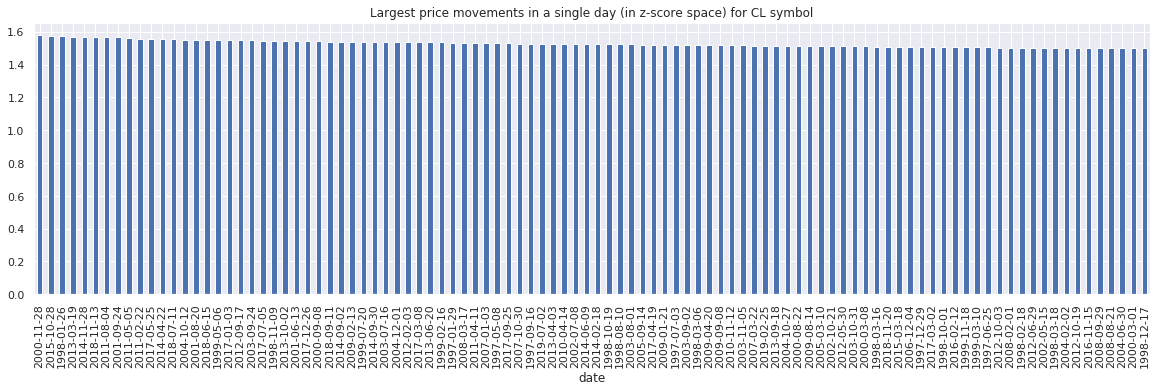

In [77]:
top_100_movements_cl.plot(kind="bar")
ax = plt.gca()
xlabels = [item.get_text()[:10] for item in ax.get_xticklabels()]
ax.set_xticklabels(xlabels)
plt.title(
    f"Largest price movements in a single day (in z-score space) for {symbol} symbol"
)
plt.show()

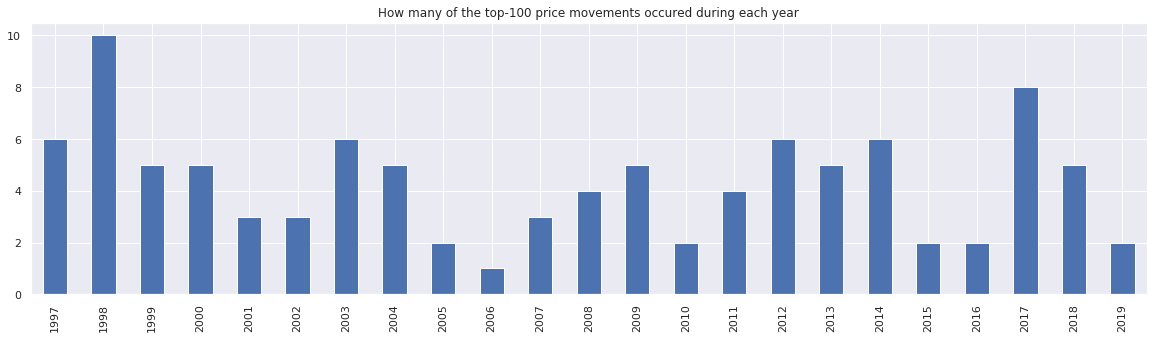

In [78]:
top_100_movements_cl.index.year.value_counts(sort=False).plot(kind="bar")
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

## Largest movement for energy group

In [79]:
group = "Energy"

In [80]:
commodity_symbols_kibot[group]

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [81]:
zscored_diffs = []
for symbol in commodity_symbols_kibot[group]:
    zscored_diff = pma.get_zscored_prices_diff(daily_price_dict_df, symbol)
    zscored_diffs.append(zscored_diff)

In [82]:
zscored_diffs = pd.concat(zscored_diffs, axis=1)
zscored_diffs.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
date,,,,,,,,,,,,,,,,,,,,,
1995-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-10-30,NaN,NaN,NaN,NaN,NaN,NaN,1.267490,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-10-31,NaN,NaN,NaN,NaN,NaN,NaN,1.210127,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-11-01,NaN,NaN,NaN,NaN,NaN,NaN,1.284967,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-11-02,NaN,NaN,NaN,NaN,NaN,NaN,1.423710,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
mean_zscored_diffs = zscored_diffs.mean(axis=1, skipna=True)

In [84]:
mean_zscored_diffs.head()

date
1995-10-27         NaN
1995-10-30    1.267490
1995-10-31    1.210127
1995-11-01    1.284967
1995-11-02    1.423710
dtype: float64

In [85]:
mean_zscored_diffs.tail()

date
2019-07-15    0.686616
2019-07-16    0.897046
2019-07-17    0.592995
2019-07-18    0.868561
2019-07-19    0.899710
dtype: float64

In [86]:
mean_zscored_diffs.sort_values(ascending=False).head(100)

date
2002-01-21    1.561397
1999-02-15    1.531754
1998-05-25    1.498766
1997-06-25    1.496382
1998-03-18    1.478831
1997-07-03    1.465216
1997-05-08    1.455698
1996-10-03    1.454727
1996-03-11    1.431566
1995-11-02    1.423710
1996-04-12    1.419908
1998-11-09    1.418834
1997-10-06    1.413333
1997-10-28    1.402530
1996-04-23    1.399250
1995-12-28    1.393430
1996-03-21    1.392654
1998-03-16    1.390549
1996-10-31    1.388940
1998-01-30    1.388016
1996-02-13    1.386566
1995-11-16    1.382904
1996-08-16    1.380279
1996-08-15    1.379898
1997-12-10    1.379594
1998-05-21    1.375077
1997-04-16    1.374017
1998-02-18    1.370624
1996-05-13    1.364952
1999-05-06    1.364406
                ...   
1999-10-28    1.258284
2005-02-21    1.256080
1996-10-23    1.255056
1999-09-02    1.254971
1997-11-10    1.253813
1997-07-18    1.251871
2013-06-20    1.250853
2002-05-01    1.247730
1996-06-27    1.245765
1997-05-27    1.245136
1995-12-27    1.243050
1999-02-26    1.241805
1997-0

## Largest movements for each group

In [87]:
top_100_movements_by_group = {
    group: pma.get_top_movements_by_group(
        daily_price_dict_df, commodity_symbols_kibot, group
    )
    for group in commodity_symbols_kibot.keys()
}

In [88]:
top_100_movements_by_group.keys()

dict_keys(['Energy', 'Agriculture', 'Metals'])

In [89]:
top_100_movements_by_group["Energy"].head()

date
2002-01-21    1.561397
1999-02-15    1.531754
1998-05-25    1.498766
1997-06-25    1.496382
1998-03-18    1.478831
dtype: float64

In [90]:
top_100_movements_by_group["Agriculture"].head()

date
2017-01-02    1.442423
2014-05-26    1.422618
2017-01-16    1.413989
2005-01-03    1.402492
2014-02-03    1.395559
dtype: float64

In [91]:
top_100_movements_by_group["Metals"].head()

date
1994-01-25    1.585327
1994-02-14    1.581903
2011-11-24    1.580149
2014-07-04    1.576312
2011-01-17    1.559374
dtype: float64

# 5-minute price movements

## Load 1-minute prices

In [92]:
minutely_metadata = kut.read_metadata1()

In [93]:
minutely_metadata.head()

,Symbol,Link,Description
All_Futures_Contracts_1min.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019
4,JYG18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN FEBRUARY 2018
5,JYG19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN FEBRUARY 2019


In [94]:
np.array_equal(
    minutely_metadata["Symbol"].values, minutely_metadata["Symbol"].values
)

True

In [ ]:
file_name = "/data/kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"

minutely_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, file_name, nrows=None
)

minutely_price_dict_df["CL"].tail(2)

In [ ]:
minutely_price_dict_df["CL"].head()

In [ ]:
five_min_price_dict_df = {
    symbol: minutely_price_dict_df[symbol].resample("5Min").sum()
    for symbol in minutely_price_dict_df.keys()
}

## Top movements for a symbol

In [ ]:
symbol = "CL"

In [ ]:
top_100_movements_cl_5_min = pma.get_top_movements_for_symbol(
    five_min_price_dict_df, symbol
)

In [ ]:
top_100_movements_cl_5_min["CL"].head()

In [ ]:
top_100_movements_cl_5_min.plot(kind="bar")
plt.title(
    f"Largest price movements in in a 5 min interval (in z-score space) for {symbol} symbol"
)
plt.show()

In [ ]:
print(f"Top 100 of the price movements for {symbol} occur at the following time:")
print(pd.Series(top_100_movements_cl_5_min.index).dt.time.value_counts())

## Largest movements for energy group

In [ ]:
group = "Energy"

In [ ]:
commodity_symbols_kibot[group]

In [ ]:
pma.get_top_movements_by_group(
    five_min_price_dict_df, commodity_symbols_kibot, group
)

## Largest movements for each group

In [ ]:
top_100_5_min_movements_by_group = {
    group: pma.get_top_movements_by_group(
        five_min_price_dict_df, commodity_symbols_kibot, group
    )
    for group in tqdm(commodity_symbols_kibot.keys())
}

In [ ]:
{
    group: head_prices_group.head()
    for group, head_prices_group in top_100_5_min_movements_by_group.items()
}

In [ ]:
dd